# Projet 3 : Concevez une application au service de la santé publique<br>- Phase de nettoyage
## Sommaire
* [Importation des bibliothèques](#import_bib)
* [Aperçu du jeu de données](#aperc_donnees)
    * [Chargement des dix premières lignes](#charg_dix)
    * [Première vérification des macronutriments par rapport à leurs valeurs constitutives](#prem_verif_macro)
* [Lecture du jeu de données OpenFoodFacts](#lect_donnees)
* [Suppression des colonnes indésirables](#sup_col)
* [Correction des valeurs impossibles des constituants des macronutriments](#corr_constit)
    * [Modification du dataframe](#corr_constit_mod_df)
    * [Graphique à barres empilées montrant les valeurs corrigées](#graph_corr_constit)
    * [Retrait de la colonne d'amidon](#ret_amid)

In [1]:
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsRegressor
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from collections import OrderedDict
import os
import pandas as pd
import pickle
import re


## Aperçu du jeu de données <a class="anchor" id="aperc_donnees"></a>
### Chargement des dix premières lignes <a class="anchor" id="charg_dix"></a>
* Les dix premières lignes de l'ensemble de données sont chargées avec l'encodage et les délimiteurs indiqués par Open Food Facts.
    * Les colonnes / caractéristiques sélectionnées sont celles qui concernent l'identification du produit, la catégorie, la teneur énergétique, les quantités de macronutriments et les constituants des macronutriments, ainsi que le sel, qui est également pertinent pour la salubrité des produits.
    * Les lignes sont affichées avec leur plage complète de colonnes.

In [22]:
products_df_preview = pd.read_csv(
    "en.openfoodfacts.org.products.csv",
    delimiter="\t",
    encoding="utf-8",
    low_memory=False,
    nrows=10,
    dtype={"code": "string"},
)
with pd.option_context("display.max_columns", None):
    display(
        products_df_preview[
            [
                "code",
                "product_name",
                "brands",
                "categories_en",
                "pnns_groups_1",
                "pnns_groups_2",
                "food_groups_en",
                "main_category_en",
                "energy_100g",
                "energy-kj_100g",
                "energy-kcal_100g",
                "proteins_100g",
                "carbohydrates_100g",
                "sugars_100g",
                "starch_100g",
                "fat_100g",
                "saturated-fat_100g",
                "monounsaturated-fat_100g",
                "polyunsaturated-fat_100g",
                "omega-3-fat_100g",
                "omega-6-fat_100g",
                "trans-fat_100g",
                "fiber_100g",
                "sodium_100g",
                "alcohol_100g",
                "glycemic-index_100g",
            ]
        ]
    )


,code,product_name,brands,categories_en,pnns_groups_1,pnns_groups_2,food_groups_en,main_category_en,energy_100g,energy-kj_100g,energy-kcal_100g,proteins_100g,carbohydrates_100g,sugars_100g,starch_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,omega-6-fat_100g,trans-fat_100g,fiber_100g,sodium_100g,alcohol_100g,glycemic-index_100g
0,00000000000000225,jeunes pousses,endives,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000000207025004,Andrè,NaN,NaN,unknown,unknown,NaN,NaN,690.0,NaN,165.0,1.5,65.0,12.60,NaN,2.0,2.00,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
2,00000000000003429145,L.casei,NaN,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,2.7,9.8,9.80,NaN,1.4,0.90,NaN,NaN,NaN,NaN,NaN,NaN,0.040,NaN,NaN
3,00000000000026772226,Skyr,Danone,"Dairies,Desserts,Fermented foods,Fermented milk products,Cheeses,Dairy desserts,Cream cheeses,Skyr",Milk and dairy products,Dairy desserts,"Milk and dairy products,Dairy desserts",Skyr,238.0,NaN,57.0,10.0,3.9,3.90,NaN,0.2,0.10,NaN,NaN,NaN,NaN,NaN,NaN,0.036,NaN,NaN
4,0000000000017,Vitória crackers,NaN,NaN,unknown,unknown,NaN,NaN,1569.0,NaN,375.0,7.8,70.1,15.00,NaN,7.0,3.08,NaN,NaN,NaN,NaN,NaN,NaN,0.560,NaN,NaN
5,0000000000031,Cacao,NaN,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,000000000003327986,Filetes de pollo empanado,NaN,NaN,unknown,unknown,NaN,NaN,685.8,685.8,163.9,15.3,NaN,NaN,NaN,1.9,1.00,NaN,NaN,NaN,NaN,NaN,NaN,0.440,NaN,NaN
7,000000000004128579,Burger Meat Pollo,NaN,NaN,unknown,unknown,NaN,NaN,812.0,NaN,194.0,18.0,5.7,0.05,NaN,11.0,3.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,000000000004622327,Hamburguesas de ternera 100%,NaN,NaN,unknown,unknown,NaN,NaN,3661.0,NaN,874.9,15.7,2.6,1.00,NaN,15.1,6.10,NaN,NaN,NaN,NaN,NaN,NaN,0.840,NaN,NaN
9,00000000001,hyde icon,NaN,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Première vérification des macronutriments par rapport à leurs valeurs constitutives <a class="anchor" id="prem_verif_macro"></a>
* La teneur en kJ d'un produit est de préférence extraite de la colonne « energy-kj_100g », si celle-ci n'est pas disponible elle est extraite de la colonne « energy_100g » censée contenir des valeurs en kJ.
* Si la valeur kJ n'est pas nulle, une autre variable a une constante de conversion appliquée pour donner une valeur kcal approximative.
* La valeur kcal est extraite de la ligne "energy-kcal_100g", qui, si elle est nulle, est définie sur 0.
* Si des macronutriments ne sont pas présents, leurs noms sont ajoutés à une chaîne de macros manquantes. S'ils sont présents, leurs quantités sont multipliées par une valeur approximative de kcal par gramme et elles sont additionnées pour donner un total estimé de kcal.
* Les valeurs énergétiques déclarées, converties et estimées sont imprimées ainsi que les macronutriments manquants pour chaque ligne.
    * Idéalement, si les données sont cohérentes, les valeurs de kcal converties à partir de kJ, de kcal déclaré et de kcal estimé devraient être approximativement les mêmes, et il ne devrait pas y avoir de macronutriments manquants.

In [28]:
for index, row in products_df_preview.iterrows():
    kj = row["energy-kj_100g"]
    kcal = row["energy-kcal_100g"]
    fat = row["fat_100g"]
    carbs = row["carbohydrates_100g"]
    fiber = row["fiber_100g"]
    protein = row["proteins_100g"]
    alcohol = row["alcohol_100g"]
    fat_cal = carb_cal = fiber_cal = prot_cal = alc_cal = kj_to_kcal = 0
    missing = ""

    if np.isnan(kj):
        kj = row["energy_100g"]
    if not np.isnan(kj):
        kj_to_kcal = kj * 0.239006
    if np.isnan(kcal):
        kcal = 0
    if not np.isnan(fat):
        fat_cal = 9 * fat
    else:
        missing += "Fat "
    if not np.isnan(carbs):
        carb_cal = 4 * carbs
    else:
        missing += "Carbs "
    if not np.isnan(fiber):
        fiber_cal = 2 * carbs
    else:
        missing += "Fiber "
    if not np.isnan(protein):
        prot_cal = 4 * protein
    else:
        missing += "Protein "
    if not np.isnan(alcohol):
        alc_cal = 7 * alcohol
    else:
        missing += "Alcohol "

    estim_kcal = fat_cal + carb_cal + fiber_cal + prot_cal + alc_cal

    print(
        f"Stated kJ: {kj}\nkJ to kcal: {kj_to_kcal}\nStated kcal: {kcal}\nEstimated kcal: {estim_kcal}\nMissing: {missing}\n"
    )


Stated kJ: nan
kJ to kcal: 0
Stated kcal: 0
Estimated kcal: 0
Missing: Fat Carbs Fiber Protein Alcohol 

Stated kJ: 690.0
kJ to kcal: 164.91414
Stated kcal: 165.0
Estimated kcal: 414.0
Missing: Alcohol 

Stated kJ: nan
kJ to kcal: 0
Stated kcal: 0
Estimated kcal: 62.60000000000001
Missing: Fiber Alcohol 

Stated kJ: 238.0
kJ to kcal: 56.883428
Stated kcal: 57.0
Estimated kcal: 57.4
Missing: Fiber Alcohol 

Stated kJ: 1569.0
kJ to kcal: 375.000414
Stated kcal: 375.0
Estimated kcal: 374.59999999999997
Missing: Fiber Alcohol 

Stated kJ: nan
kJ to kcal: 0
Stated kcal: 0
Estimated kcal: 0
Missing: Fat Carbs Fiber Protein Alcohol 

Stated kJ: 685.8
kJ to kcal: 163.91031479999998
Stated kcal: 163.9
Estimated kcal: 78.3
Missing: Carbs Fiber Alcohol 

Stated kJ: 812.0
kJ to kcal: 194.072872
Stated kcal: 194.0
Estimated kcal: 193.8
Missing: Fiber Alcohol 

Stated kJ: 3661.0
kJ to kcal: 875.000966
Stated kcal: 874.9
Estimated kcal: 209.10000000000002
Missing: Fiber Alcohol 

Stated kJ: nan
kJ to

## Lecture du jeu de données OpenFoodFacts<a class="anchor" id="lect_donnees"></a>
* Le CSV est lu en chunks suffisamment petits pour être traités.
    * L'encodage et les délimiteurs indiqués sont paramétrés.
    * Le type de données de code-barres est défini sur chaîne pour conserver les 0 en tête.
    * Les lignes indésirables sont abandonnées.
        * Lignes manquant le feature de catégorie le plus complèt
        * Lignes manquant de macronutriments primaires
        * Lignes sans indicateur d'énergie
    * Les colonnes sont incluses en fonction des features pertinents.
        * Identification du produit
        * Catégorie(s) du produit
        * Macronutriments
        * Constituants des macronutriments
        * Autres attributs pertinents pour la santé (sodium, index glycémique)
* Les chunks sont recombinés, stocké dans une variable et enregistré dans un fichier.
* Des informations sur le dataframe sont affichées.

In [4]:
products_df = pd.DataFrame()

if not os.path.isfile("products_df.ftr"):
    chunksize = 10**5
    with pd.read_csv(
        "en.openfoodfacts.org.products.csv",
        delimiter="\t",
        encoding="utf-8",
        low_memory=False,
        chunksize=chunksize,
        dtype={"code": "string"},
    ) as reader:
        for chunk in reader:
            chunk.dropna(
                subset=[
                    "categories_en",
                    "fat_100g",
                    "carbohydrates_100g",
                    "proteins_100g",
                ],
                inplace=True,
            )
            chunk.dropna(
                subset=["energy-kj_100g", "energy-kcal_100g", "energy_100g"],
                how="all",
                inplace=True,
            )
            chunk = chunk[
                [
                    "code",
                    "product_name",
                    "brands",
                    "categories_en",
                    "pnns_groups_1",
                    "pnns_groups_2",
                    "food_groups_en",
                    "main_category_en",
                    "energy_100g",
                    "energy-kj_100g",
                    "energy-kcal_100g",
                    "proteins_100g",
                    "carbohydrates_100g",
                    "sugars_100g",
                    "starch_100g",
                    "fat_100g",
                    "saturated-fat_100g",
                    "monounsaturated-fat_100g",
                    "polyunsaturated-fat_100g",
                    "omega-3-fat_100g",
                    "omega-6-fat_100g",
                    "trans-fat_100g",
                    "fiber_100g",
                    "sodium_100g",
                    "alcohol_100g",
                    "glycemic-index_100g",
                ]
            ]
            products_df = pd.concat([products_df, chunk])
    products_df.reset_index(drop=True, inplace=True)
    products_df.to_feather("products_df.ftr")
else:
    products_df = pd.read_feather("products_df.ftr")

products_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904870 entries, 0 to 904869
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   code                      904870 non-null  string 
 1   product_name              901503 non-null  object 
 2   brands                    645608 non-null  object 
 3   categories_en             904870 non-null  object 
 4   pnns_groups_1             904870 non-null  object 
 5   pnns_groups_2             904870 non-null  object 
 6   food_groups_en            743353 non-null  object 
 7   main_category_en          904870 non-null  object 
 8   energy_100g               904870 non-null  float64
 9   energy-kj_100g            159551 non-null  float64
 10  energy-kcal_100g          864689 non-null  float64
 11  proteins_100g             904870 non-null  float64
 12  carbohydrates_100g        904870 non-null  float64
 13  sugars_100g               886136 non-null  f

## Suppression des colonnes indésirables<a class="anchor" id="sup_col"></a>
* Les colonnes "pnns_groups" n'ont pas de valeurs nulles, mais elles contiennent souvent une valeur "unknown".
* "food_groups_en" est moins complet et moins spécifique que "categories_en".
* Les colonnes "omega-fat" et "glycemic-index" contiennent trop peu de données pour être intéressantes.

In [5]:
products_df.drop(
    [
        "pnns_groups_1",
        "pnns_groups_2",
        "food_groups_en",
        "omega-3-fat_100g",
        "omega-6-fat_100g",
        "glycemic-index_100g",
    ],
    axis=1,
    inplace=True,
)


## Correction des valeurs impossibles des constituants des macronutriments<a class="anchor" id="corr_constit"></a>
### Modification du dataframe<a class="anchor" id="corr_constit_mod_df"></a>
* Une fonction est appliquée au dataframe qui :
    * Obtient la somme des constituants de chaque macronutriment en grammes
    * Compare cette somme à la quantité indiquée de chaque macronutriment en grammes
    * Si le total des constituants dépasse la valeur indiquée, la proportion de chaque constituant est convertie en pourcentage et multipliée par la valeur de macronutriment indiquée, qui est utilisée pour remplacer les valeurs aberrantes.
    * Par exemple (exagéré pour la clarté) :
        * La quantité indiquée de glucides est de 4 grammes
        * La quantité indiquée de sucres est de 6 grammes et l'amidon est de 2 grammes
        * Cela équivaut à 75% de sucre et 25% d'amidon
        * Multiplié par 4 grammes de glucides, cela donne 3 grammes de sucre et 1 gramme d'amidon
    * Cela a tendance à corriger principalement les erreurs d'arrondi.
* Le numéro de chaque valeur modifiée par colonne est stocké dans une variable et le dataframe modifié est enregistré dans un fichier.
* Le nombre et les pourcentages de valeurs modifiées sont affichés.

In [6]:
fats_crbs_tot_inval = {}
fats = [
    "saturated-fat_100g",
    "monounsaturated-fat_100g",
    "polyunsaturated-fat_100g",
    "trans-fat_100g",
]
carbs = ["sugars_100g", "starch_100g"]

for fat_crb in fats + carbs:
    fats_crbs_tot_inval[fat_crb] = 0

if not os.path.isfile("products_df2.ftr") or not os.path.isfile("fats_crbs.pkl"):

    def fix_invalid_fats_carbs(row):
        reconst_fat = np.nansum([row[fat] for fat in fats])
        if reconst_fat > row["fat_100g"]:
            for fat in fats:
                if not np.isnan(row[fat]):
                    row[fat] = round(row[fat] / reconst_fat * row["fat_100g"], 3)
                    fats_crbs_tot_inval[fat] += 1
        reconst_carbs = np.nansum([row[carb] for carb in carbs])
        if reconst_carbs > row["carbohydrates_100g"]:
            for carb in carbs:
                if not np.isnan(row[carb]):
                    row[carb] = round(
                        row[carb] / reconst_carbs * row["carbohydrates_100g"], 3
                    )
                    fats_crbs_tot_inval[carb] += 1
        return row

    products_df = products_df.apply(fix_invalid_fats_carbs, axis=1)
    products_df.to_feather("products_df2.ftr")
    with open("fats_crbs.pkl", "wb") as f:
        pickle.dump(fats_crbs_tot_inval, f)
else:
    products_df = pd.read_feather("products_df2.ftr")
    with open("fats_crbs.pkl", "rb") as f:
        fats_crbs_tot_inval = pickle.load(f)

for fat_carb in fats_crbs_tot_inval:
    corrected = fats_crbs_tot_inval[fat_carb]
    total = products_df[fat_carb].notnull().sum()
    spaces = " " * (len(max(fats + carbs, key=len)) - len(fat_carb))
    print(
        f"'{fat_carb}':{spaces} {corrected}/{total} ({round(corrected / total, 4)}%) corrected"
    )


'saturated-fat_100g':       5866/867166 (0.0068%) corrected
'monounsaturated-fat_100g': 4887/45157 (0.1082%) corrected
'polyunsaturated-fat_100g': 4894/45114 (0.1085%) corrected
'trans-fat_100g':           4339/244436 (0.0178%) corrected
'sugars_100g':              884/886136 (0.001%) corrected
'starch_100g':              70/566 (0.1237%) corrected


### Graphique à barres empilées montrant les valeurs corrigées<a class="anchor" id="graph_corr_constit"></a>

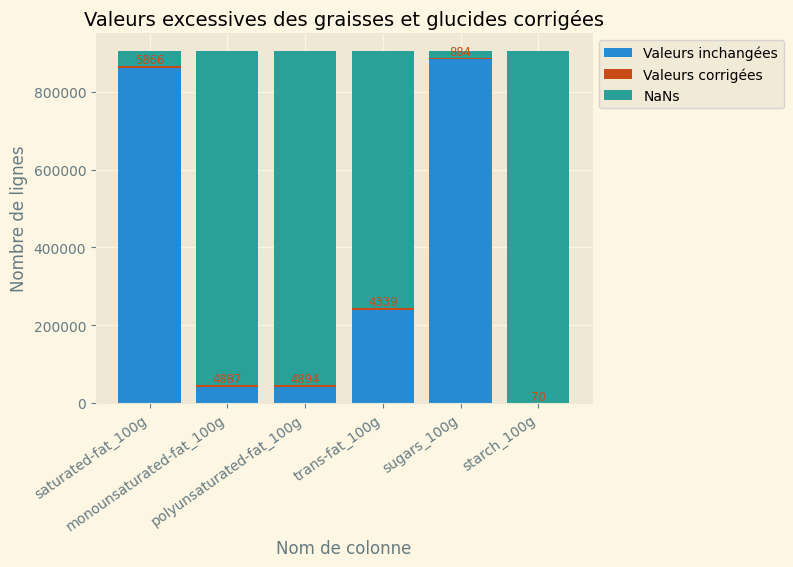

In [7]:
unch_val = np.array(
    [
        products_df[fat_carb].notnull().sum() - fats_crbs_tot_inval[fat_carb]
        for fat_carb in fats + carbs
    ]
)
ch_val = np.array([fats_crbs_tot_inval[fat_carb] for fat_carb in fats + carbs])
nans = np.array(
    [
        products_df.shape[0] - products_df[fat_carb].notnull().sum()
        for fat_carb in fats + carbs
    ]
)
ch_val_color = "C4"
plt.style.use("Solarize_Light2")
plt.bar(fats + carbs, unch_val)
plt.bar(fats + carbs, ch_val, bottom=unch_val, color=ch_val_color)
plt.bar(fats + carbs, nans, bottom=ch_val + unch_val)
for i in range(len(fats + carbs)):
    plt.text(
        i,
        unch_val[i] + ch_val[i],
        ch_val[i],
        ha="center",
        va="bottom",
        fontsize="small",
        color=ch_val_color,
    )
plt.title("Valeurs excessives des graisses et glucides corrigées", fontsize=14)
plt.xlabel("Nom de colonne")
plt.ylabel("Nombre de lignes")
plt.legend(
    ["Valeurs inchangées", "Valeurs corrigées", "NaNs"],
    bbox_to_anchor=(1, 1),
)
plt.xticks(horizontalalignment="right", rotation=35)
plt.show()


### Retrait de la colonne d'amidon<a class="anchor" id="ret_amid"></a>
La colonne d'amidon a atteint son objectif en corrigeant les valeurs de sucre pour les lignes dans lesquelles elle contenait des valeurs, mais elle manque de données suffisantes pour présenter un intérêt supplémentaire.

In [ ]:
products_df.drop("starch_100g", axis=1, inplace=True)


In [8]:
macro_maxes = {
    # 95 g : rectified grain spirit
    "alcohol_100g": 95.5,
    # 100 g : refined sugar
    "carbohydrates_100g": 100,
    # 100 g : cooking oil
    "fat_100g": 100,
    # 75 g : wheat dextrin (fiber) supplement
    "fiber_100g": 75.5,
    # 79 g : whey protein powder
    "proteins_100g": 79.5,
}
macro_lst = list(macro_maxes.keys())
inval_macros_dropped = {}

if not os.path.isfile("products_df3.ftr") or not os.path.isfile("macro_drop.pkl"):

    def check_invalid_macros(row):
        macro_inval = False
        macros_inval = []
        # comparison to NaN always False (preserves rows with NaN values)
        # water has 0 calories, so 0 is always valid
        for macro in macro_lst:
            if row[macro] < 0 or row[macro] > macro_maxes[macro]:
                macro_inval = True
                macros_inval += [macro]
            if macro_inval:
                key = "\n& ".join(macros_inval)
                if key not in inval_macros_dropped:
                    inval_macros_dropped[key] = 1
                else:
                    inval_macros_dropped[key] += 1

        return macro_inval

    inval_macro_bool_series = products_df.apply(check_invalid_macros, axis=1)
    products_df.drop(
        products_df.index[
            inval_macro_bool_series[inval_macro_bool_series].index.values
        ],
        inplace=True,
    )
    products_df.reset_index(drop=True, inplace=True)

    inval_macros_dropped = dict(
        sorted(
            dict(OrderedDict(sorted(inval_macros_dropped.items()))).items(),
            key=lambda x: x[1],
            reverse=True,
        )
    )

    products_df.to_feather("products_df3.ftr")
    with open("macro_drop.pkl", "wb") as f:
        pickle.dump(inval_macros_dropped, f)
else:
    products_df = pd.read_feather("products_df3.ftr")
    with open("macro_drop.pkl", "rb") as f:
        inval_macros_dropped = pickle.load(f)


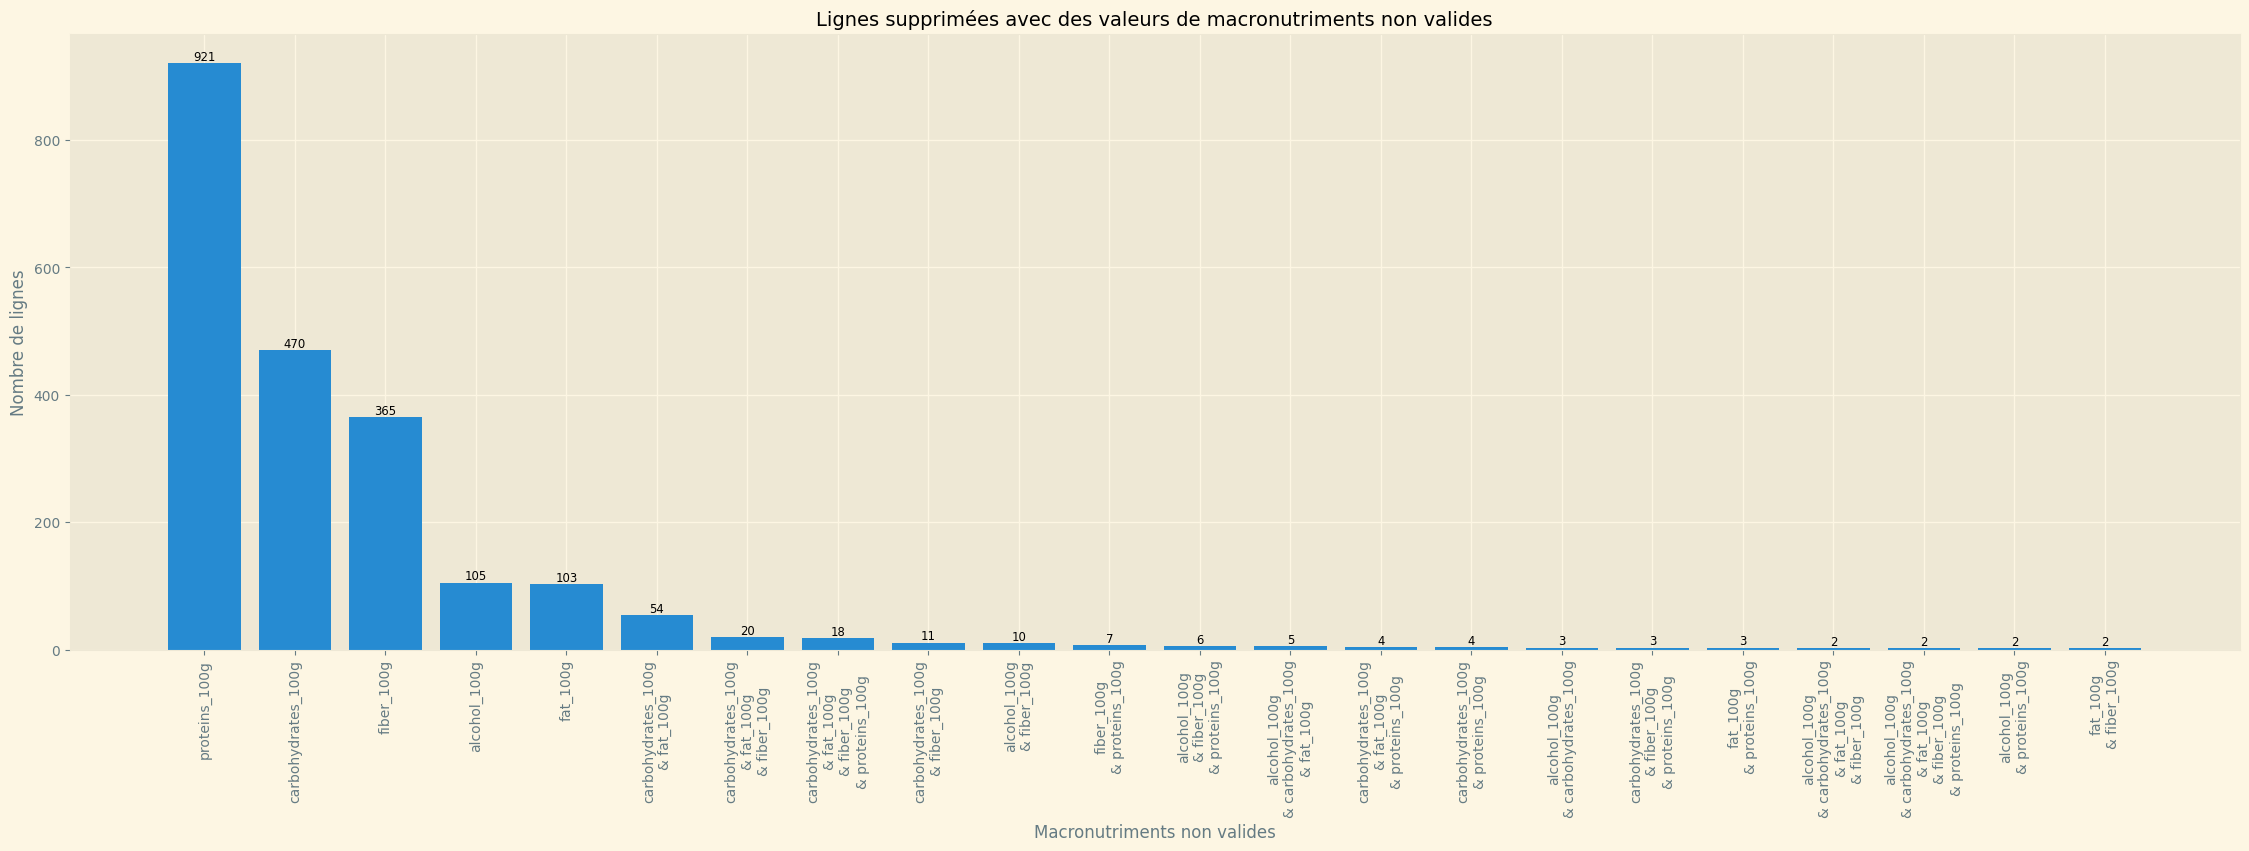

In [9]:
plt.figure(figsize=(28, 8))
plt.bar(list(inval_macros_dropped.keys()), list(inval_macros_dropped.values()))
for i in range(len(list(inval_macros_dropped.values()))):
    plt.text(
        i,
        list(inval_macros_dropped.values())[i],
        list(inval_macros_dropped.values())[i],
        ha="center",
        va="bottom",
        fontsize="small",
    )
plt.title(
    "Lignes supprimées avec des valeurs de macronutriments non valides", fontsize=14
)
plt.xlabel("Macronutriments non valides")
plt.ylabel("Nombre de lignes")
plt.xticks(horizontalalignment="center", rotation=90)
plt.show()


In [10]:
ener_indics = ["energy-kj_100g", "energy-kcal_100g", "energy_100g"]
max_en_ind_len = len(max(ener_indics, key=len))
print("Negative energy values replaced by NaN:")
for ener_indic in ener_indics:
    old_nans = products_df[ener_indic].isna().sum()
    products_df.mask(products_df[ener_indic] < 0, np.nan, inplace=True)
    new_nans = products_df[ener_indic].isna().sum() - old_nans
    spaces = " " * (max_en_ind_len - len(ener_indic))
    print(f"{ener_indic}:{spaces} {new_nans}")


Negative energy values replaced by NaN:
energy-kj_100g:   0
energy-kcal_100g: 0
energy_100g:      0


In [11]:
if not os.path.isfile("products_df4.ftr") or not os.path.isfile("kcal_vals.pkl"):
    kcal_vals = {
        "orig_total_rows": products_df.shape[0],
        "orig_kcal": products_df["energy-kcal_100g"].notnull().sum(),
        "kcal_from_ener": 0,
        "remain_orig_kcal": 0,
        "kcal_from_kj": 0,
    }

    # caloric conversions taken from:
    # Eugénie Auvinet, Caroline Hirschauer et Anne-Laure Meunier,
    # Alimentations, Nutrition et Régimes, Connaissances . Outils . Applications, Studyrama, 2018, 1134 p.
    # and
    # REGULATION (EU) No 1169/2011 OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL

    # error margin taken from:
    # FOOD AND AGRICULTURE ORGANIZATION OF THE UNITED NATIONS FOOD AND NUTRITION PAPER 77
    # Food energy - methods of analysis and conversion factors
    # Report of a Technical Workshop, Rome, 3-6 December 2002

    def correct_kcal(row):
        corr_kcal = np.nan
        # energy always present and should be given in kJ
        kcal_from_ener = row["energy_100g"] * 0.239
        kcal_stated = (
            row["energy-kcal_100g"] if not np.isnan(row["energy-kcal_100g"]) else 0
        )
        kcal_from_kj = (
            row["energy-kj_100g"] if not np.isnan(row["energy-kj_100g"]) else 0
        ) * 0.239
        # fat, protein and carbohydrates always present
        kcal_reconst = (
            # 9 kcal per gram fat (always present)
            row["fat_100g"] * 8.9913958
            +
            # 7 kcal per gram alcohol
            (row["alcohol_100g"] if not np.isnan(row["alcohol_100g"]) else 0)
            * 6.9933078
            +
            # 4 kcal per gram protein (always present)
            row["proteins_100g"] * 3.9961759
            +
            # 4 kcal per gram carbohydrates (always present)
            row["carbohydrates_100g"] * 3.9961759
            +
            # 2 kcal per gram fiber
            (row["fiber_100g"] if not np.isnan(row["fiber_100g"]) else 0) * 1.91205
        )
        # if the difference between the stated energy and reconstructed energy match within the
        # error margin then stated energy is deemed valid
        err_mar = kcal_reconst * 0.06
        if abs(kcal_from_ener - kcal_reconst) <= err_mar:
            corr_kcal = round(kcal_from_ener)
            kcal_vals["kcal_from_ener"] += 1
        # comparison to stated kcal
        elif abs(kcal_stated - kcal_reconst) <= err_mar:
            corr_kcal = kcal_stated
            kcal_vals["remain_orig_kcal"] += 1
        # comparison to stated kJ
        elif abs(kcal_from_kj - kcal_reconst) <= err_mar:
            corr_kcal = round(kcal_from_kj)
            kcal_vals["kcal_from_kj"] += 1
        # if none of the stated energy values match the reconstructed value from macronutrients the corrected kcal stays NaN
        return corr_kcal

    products_df["energy-kcal_100g"] = products_df.apply(correct_kcal, axis=1)
    products_df.dropna(subset=["energy-kcal_100g"], inplace=True)
    products_df.drop(["energy-kj_100g", "energy_100g"], axis=1, inplace=True)
    products_df.reset_index(drop=True, inplace=True)
    products_df.to_feather("products_df4.ftr")
    with open("kcal_vals.pkl", "wb") as f:
        pickle.dump(kcal_vals, f)
else:
    products_df = pd.read_feather("products_df4.ftr")
    with open("kcal_vals.pkl", "rb") as f:
        kcal_vals = pickle.load(f)

products_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702407 entries, 0 to 702406
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   code                      702407 non-null  object 
 1   product_name              699564 non-null  object 
 2   brands                    512717 non-null  object 
 3   categories_en             702407 non-null  object 
 4   pnns_groups_1             702407 non-null  object 
 5   pnns_groups_2             702407 non-null  object 
 6   food_groups_en            592089 non-null  object 
 7   main_category_en          702407 non-null  object 
 8   energy-kcal_100g          702407 non-null  float64
 9   proteins_100g             702407 non-null  float64
 10  carbohydrates_100g        702407 non-null  float64
 11  sugars_100g               687819 non-null  float64
 12  starch_100g               492 non-null     float64
 13  fat_100g                  702407 non-null  f

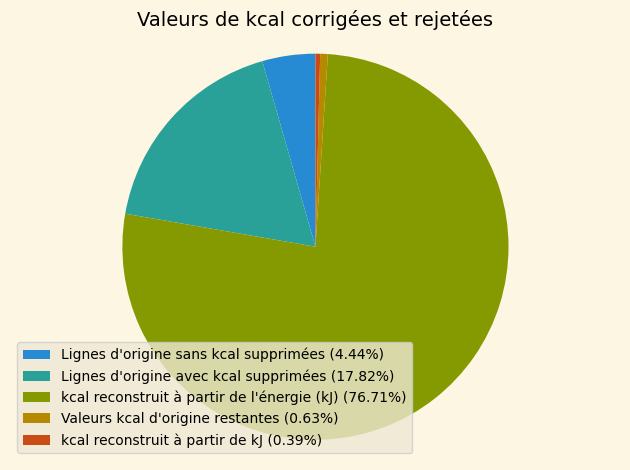

In [12]:
kcal_from_ener = kcal_vals["kcal_from_ener"]
remain_orig_kcal = kcal_vals["remain_orig_kcal"]
kcal_from_kj = kcal_vals["kcal_from_kj"]
orig_kcal_dropped = kcal_vals["orig_kcal"] - (
    kcal_from_ener + remain_orig_kcal + kcal_from_kj
)
orig_row_wo_kcal_dropped = kcal_vals["orig_total_rows"] - kcal_vals["orig_kcal"]
patches, texts = plt.pie(
    [
        orig_row_wo_kcal_dropped,
        orig_kcal_dropped,
        kcal_from_ener,
        remain_orig_kcal,
        kcal_from_kj,
    ],
    startangle=90,
)
plt.legend(
    patches,
    [
        f"Lignes d'origine sans kcal supprimées ({round(orig_row_wo_kcal_dropped / kcal_vals['orig_total_rows'] * 100, 2)}%)",
        f"Lignes d'origine avec kcal supprimées ({round(orig_kcal_dropped / kcal_vals['orig_total_rows'] * 100, 2)}%)",
        f"kcal reconstruit à partir de l'énergie (kJ) ({round(kcal_from_ener / kcal_vals['orig_total_rows'] * 100, 2)}%)",
        f"Valeurs kcal d'origine restantes ({round(remain_orig_kcal / kcal_vals['orig_total_rows'] * 100, 2)}%)",
        f"kcal reconstruit à partir de kJ ({round(kcal_from_kj / kcal_vals['orig_total_rows'] * 100, 2)}%)",
    ],
    loc="best",
)
plt.title("Valeurs de kcal corrigées et rejetées", fontsize=14)
plt.axis("equal")
plt.tight_layout()
plt.show()


In [14]:
products_df.insert(5, "primary_category", "")
products_df.insert(6, "secondary_category", "")
products_df.insert(7, "tertiary_category", "")

# string contains hypens and no spaces or starts with language code (applies almost exclusively to non-english categories)
inval_categ_regex = re.compile(r"(?=^.*-.*$)^\S*$|^\w\w:.*$")


def clean_categs(row):
    new_categs = []
    for i in reversed(row["categories_en"].split(",")):
        if not re.match(inval_categ_regex, i):
            new_categs += [i]
        if len(new_categs) == 3:
            break
    for i in range(len(new_categs)):
        if i == 0:
            row["primary_category"] = new_categs[i]
        elif i == 1:
            row["secondary_category"] = new_categs[i]
        else:
            row["tertiary_category"] = new_categs[i]
    return row


products_df = products_df.apply(clean_categs, axis=1)
products_df.drop(["categories_en"], axis=1, inplace=True)
products_df.drop(["main_category_en"], axis=1, inplace=True)

pd.set_option("display.max_colwidth", None)
products_df.head()


,code,product_name,brands,primary_category,secondary_category,tertiary_category,energy-kcal_100g,proteins_100g,carbohydrates_100g,sugars_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,trans-fat_100g,fiber_100g,sodium_100g,alcohol_100g
0,00000000000026772226,Skyr,Danone,Skyr,Cream cheeses,Dairy desserts,57.0,10.0,3.9,3.9,0.2,0.1,NaN,NaN,NaN,NaN,0.036,NaN
1,0000000001885,Compote de poire,Crous,Pear compotes,Compotes,Fruits based foods,157.0,0.6,36.0,27.0,0.0,0.0,NaN,NaN,NaN,3.6,0.000,NaN
2,0000000002257,Salade de macedoine de légumes,None,Vegetables macedoines,Cold starters,Starters,143.0,1.9,3.9,1.0,12.7,1.0,NaN,NaN,NaN,NaN,0.108,NaN
3,0000000005005,Abondance,None,Abondance,French cheeses,Cheeses,397.0,25.0,0.1,0.1,33.0,21.6,NaN,NaN,NaN,NaN,0.520,NaN
4,0000000005166,cuisse de poulet direct au four curry,None,Chicken thighs,Chickens,Poultries,197.0,17.0,3.0,0.9,13.0,4.0,NaN,NaN,NaN,NaN,0.440,NaN


In [15]:
pri_categ_top_counts = (
    products_df["primary_category"].value_counts().take(list(range(250)))
)
sec_categ_top_counts = (
    products_df["secondary_category"].value_counts().take(list(range(250)))
)
all_categ_top_counts = pd.concat([pri_categ_top_counts, sec_categ_top_counts])
all_categ_uniq_top_counts = pd.Series(0, index=list(set(all_categ_top_counts.index)))
for index, value in all_categ_top_counts.items():
    all_categ_uniq_top_counts[index] += value
all_categ_uniq_top_counts.sort_values(ascending=False, inplace=True)
print(all_categ_uniq_top_counts.index.to_list())


['', 'Biscuits and cakes', 'Sauces', 'Snacks', 'Biscuits', 'Confectioneries', 'Fermented milk products', 'Cheeses', 'Beverages', 'Frozen foods', 'Groceries', 'Cereals and their products', 'Sweet snacks', 'Breads', 'Cereals and potatoes', 'Prepared meats', 'Yogurts', 'Meals', 'Cakes', 'Meats', 'Pastas', 'Chocolates', 'Frozen desserts', 'Chocolate candies', 'Plant-based beverages', 'Hams', 'Plant-based foods', 'Pastries', 'Milks', 'Dairies', 'Virgin olive oils', 'Extra-virgin olive oils', 'Sausages', 'Sweetened beverages', 'Chickens', 'Condiments', 'Candies', 'Dark chocolates', 'Sodas', 'White hams', 'Vegetable oils', 'Crisps', 'Jams', 'Pizzas', 'Breakfast cereals', 'Waters', 'Cured sausages', 'Ice creams', 'French cheeses', 'Fruit juices', 'Carbonated drinks', 'Nuts', 'Pizzas pies and quiches', 'Bonbons', 'Sweet spreads', 'Dried fruits', 'Vegetable fats', 'Brioches', 'Berry jams', 'Fruits based foods', 'Poultries', 'Pork', 'Tomato sauces', 'Rices', 'Crackers', 'Fishes', 'Appetizers', 'I

In [16]:
selected_categs = [
    "Biscuits",
    "Cheeses",
    "Sweet snacks",
    "Breads",
    "Cakes",
    "Chocolates",
    "Hams",
    "Pastries",
    "Milks",
    "Sausages",
    "Chickens",
    "Candies",
    "Sodas",
    "Vegetable oils",
    "Jams",
    "Pizzas",
    "Breakfast cereals",
    "Waters",
    "Ice creams",
    "Fruit juices",
    "Nuts",
    "Sweet spreads",
    "Dried fruits",
    "Pork",
    "Tomato sauces",
    "Rices",
    "Appetizers",
    "Soups",
    "Seafood",
    "Smoked salmons",
    "Mayonnaises",
    "Salty snacks",
    "Sandwiches",
    "Ice creams and sorbets",
    "Fruit yogurts",
    "Noodles",
    "Meat analogues",
    "Microwave meals",
    "Prepared salads",
    "Butters",
    "Pasta dishes",
    "Smoked fishes",
    "Cream cheeses",
    "Dips",
    "Frozen seafood",
    "Canned meals",
    "Tunas",
    "Dry pastas",
    "Mustards",
    "Pestos",
]
products_df = pd.concat(
    [
        products_df,
        pd.DataFrame(
            0, index=list(range(len(products_df.index))), columns=selected_categs
        ),
    ],
    axis=1,
)
products_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702407 entries, 0 to 702406
Data columns (total 68 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   code                      702407 non-null  object 
 1   product_name              699564 non-null  object 
 2   brands                    512717 non-null  object 
 3   primary_category          702407 non-null  object 
 4   secondary_category        702407 non-null  object 
 5   tertiary_category         702407 non-null  object 
 6   energy-kcal_100g          702407 non-null  float64
 7   proteins_100g             702407 non-null  float64
 8   carbohydrates_100g        702407 non-null  float64
 9   sugars_100g               687819 non-null  float64
 10  fat_100g                  702407 non-null  float64
 11  saturated-fat_100g        677662 non-null  float64
 12  monounsaturated-fat_100g  32653 non-null   float64
 13  polyunsaturated-fat_100g  32625 non-null   f

In [17]:
def one_hot_categ(row):
    if row["primary_category"] in selected_categs:
        row[row["primary_category"]] = 1
    elif row["secondary_category"] in selected_categs:
        row[row["secondary_category"]] = 1
    elif row["tertiary_category"] in selected_categs:
        row[row["tertiary_category"]] = 1
    return row


products_df = products_df.apply(one_hot_categ, axis=1)

with pd.option_context("display.max_columns", None):
    display(products_df)
    display(
        pd.DataFrame(
            products_df[selected_categs].sum(axis=1).tolist(), columns=["cat_cnt"]
        )
        .groupby("cat_cnt")
        .size()
    )


,code,product_name,brands,primary_category,secondary_category,tertiary_category,energy-kcal_100g,proteins_100g,carbohydrates_100g,sugars_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,trans-fat_100g,fiber_100g,sodium_100g,alcohol_100g,Biscuits,Cheeses,Sweet snacks,Breads,Cakes,Chocolates,Hams,Pastries,Milks,Sausages,Chickens,Candies,Sodas,Vegetable oils,Jams,Pizzas,Breakfast cereals,Waters,Ice creams,Fruit juices,Nuts,Sweet spreads,Dried fruits,Pork,Tomato sauces,Rices,Appetizers,Soups,Seafood,Smoked salmons,Mayonnaises,Salty snacks,Sandwiches,Ice creams and sorbets,Fruit yogurts,Noodles,Meat analogues,Microwave meals,Prepared salads,Butters,Pasta dishes,Smoked fishes,Cream cheeses,Dips,Frozen seafood,Canned meals,Tunas,Dry pastas,Mustards,Pestos
0,00000000000026772226,Skyr,Danone,Skyr,Cream cheeses,Dairy desserts,57.0,10.0,3.9,3.9,0.2,0.1,NaN,NaN,NaN,NaN,0.036,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0000000001885,Compote de poire,Crous,Pear compotes,Compotes,Fruits based foods,157.0,0.6,36.0,27.0,0.0,0.0,NaN,NaN,NaN,3.6,0.000,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0000000002257,Salade de macedoine de légumes,None,Vegetables macedoines,Cold starters,Starters,143.0,1.9,3.9,1.0,12.7,1.0,NaN,NaN,NaN,NaN,0.108,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0000000005005,Abondance,None,Abondance,French cheeses,Cheeses,397.0,25.0,0.1,0.1,33.0,21.6,NaN,NaN,NaN,NaN,0.520,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0000000005166,cuisse de poulet direct au four curry,None,Chicken thighs,Chickens,Poultries,197.0,17.0,3.0,0.9,13.0,4.0,NaN,NaN,NaN,NaN,0.440,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702402,9999991042742,Mousse au chocolat noir,None,Chocolate mousses,Chocolate desserts,Desserts,346.0,6.0,19.0,18.0,27.0,17.0,NaN,NaN,NaN,NaN,0.076,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
702403,9999991149090,Riz parfumé,King Elephant,Aromatic rices,Rices,Cereal grains,351.0,7.0,80.0,0.0,0.5,0.0,NaN,NaN,NaN,NaN,0.000,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
702404,9999999004360,Minis beignets,None,Sweet Fritters,Sweet snacks,Snacks,333.0,7.4,30.9,10.4,20.2,6.0,NaN,NaN,NaN,NaN,0.440,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
702405,9999999175305,Erdbeerkuchen 1019g tiefgefroren,Coppenrath & Wiese,Cakes,Biscuits and cakes,,221.0,2.6,35.0,24.0,7.6,4.8,NaN,NaN,NaN,NaN,0.112,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


cat_cnt
0    404297
1    298110
dtype: int64

In [18]:
products_df_compl_rows = products_df.loc[
    (~np.isnan(products_df["sugars_100g"]))
    & (~np.isnan(products_df["saturated-fat_100g"]))
    & (~np.isnan(products_df["monounsaturated-fat_100g"]))
    & (~np.isnan(products_df["polyunsaturated-fat_100g"]))
    & (~np.isnan(products_df["trans-fat_100g"]))
    & (~np.isnan(products_df["fiber_100g"]))
    & (~np.isnan(products_df["sodium_100g"]))
]
sel_categ_w_suff_compl = []
for categ in selected_categs:
    count = products_df_compl_rows.loc[products_df_compl_rows[categ] == 1].shape[0]
    if count >= 50:
        print(f"{categ} : {count}")
        sel_categ_w_suff_compl += [categ]


Biscuits : 2387
Cheeses : 287
Sweet snacks : 268
Breads : 2209
Cakes : 878
Pastries : 569
Milks : 188
Vegetable oils : 440
Pizzas : 333
Breakfast cereals : 114
Rices : 71
Appetizers : 289
Soups : 215
Seafood : 398
Mayonnaises : 71
Noodles : 127
Pasta dishes : 191
Dips : 68
Frozen seafood : 256
Canned meals : 513
Tunas : 186


In [19]:
knns = {}
nutri_facts_to_fill = [
    "sugars_100g",
    "saturated-fat_100g",
    "monounsaturated-fat_100g",
    "polyunsaturated-fat_100g",
    "trans-fat_100g",
    "fiber_100g",
    "sodium_100g",
]

if not os.path.isfile("categ_knns.pkl"):
    for categ in sel_categ_w_suff_compl:
        products_df_categ_compl = products_df_compl_rows.loc[
            products_df_compl_rows[categ] == 1
        ]
        X = products_df_categ_compl[
            ["energy-kcal_100g", "proteins_100g", "carbohydrates_100g", "fat_100g"]
        ].to_numpy()
        y = products_df_categ_compl[nutri_facts_to_fill].to_numpy()
        error = []
        for k in range(1, 50):
            knn = KNeighborsRegressor(n_neighbors=k)
            targ_pred = cross_val_predict(knn, X, y)
            error.append(math.sqrt(mean_squared_error(y, targ_pred)))
        knn = KNeighborsRegressor(n_neighbors=(error.index(min(error)) + 1))
        knn.fit(X, y)
        knns[categ] = knn
    with open("categ_knns.pkl", "wb") as f:
        pickle.dump(knns, f)
else:
    with open("categ_knns.pkl", "rb") as f:
        knns = pickle.load(f)

display(knns)


{'Biscuits': KNeighborsRegressor(n_neighbors=10),
 'Cheeses': KNeighborsRegressor(n_neighbors=49),
 'Sweet snacks': KNeighborsRegressor(n_neighbors=1),
 'Breads': KNeighborsRegressor(n_neighbors=13),
 'Cakes': KNeighborsRegressor(n_neighbors=13),
 'Pastries': KNeighborsRegressor(n_neighbors=49),
 'Milks': KNeighborsRegressor(n_neighbors=2),
 'Vegetable oils': KNeighborsRegressor(n_neighbors=37),
 'Pizzas': KNeighborsRegressor(n_neighbors=9),
 'Breakfast cereals': KNeighborsRegressor(n_neighbors=4),
 'Rices': KNeighborsRegressor(n_neighbors=1),
 'Appetizers': KNeighborsRegressor(n_neighbors=49),
 'Soups': KNeighborsRegressor(n_neighbors=3),
 'Seafood': KNeighborsRegressor(),
 'Mayonnaises': KNeighborsRegressor(n_neighbors=7),
 'Noodles': KNeighborsRegressor(n_neighbors=4),
 'Pasta dishes': KNeighborsRegressor(n_neighbors=2),
 'Dips': KNeighborsRegressor(n_neighbors=8),
 'Frozen seafood': KNeighborsRegressor(n_neighbors=34),
 'Canned meals': KNeighborsRegressor(n_neighbors=2),
 'Tunas': 

In [20]:
if not os.path.isfile("products_df5.ftr") or not os.path.isfile("nutri_facts.pkl"):

    def fill_nutri_facts(row, categ):
        y = knns[categ].predict(
            [
                row[
                    [
                        "energy-kcal_100g",
                        "proteins_100g",
                        "carbohydrates_100g",
                        "fat_100g",
                    ]
                ].to_numpy()
            ]
        )[0]

        for i in range(len(nutri_facts_to_fill)):
            if np.isnan(row[nutri_facts_to_fill[i]]):
                row[nutri_facts_to_fill[i]] = y[i]

        return row

    nutri_facts_old_new = {}

    for nutri_fact in nutri_facts_to_fill:
        nutri_facts_old_new[nutri_fact] = [products_df[nutri_fact].notnull().sum(), 0]

    for categ in sel_categ_w_suff_compl:
        categ_rows_to_fill_nf = products_df.loc[
            (products_df[categ] == 1)
            & (
                (np.isnan(products_df["sugars_100g"]))
                | (np.isnan(products_df["saturated-fat_100g"]))
                | (np.isnan(products_df["monounsaturated-fat_100g"]))
                | (np.isnan(products_df["polyunsaturated-fat_100g"]))
                | (np.isnan(products_df["trans-fat_100g"]))
                | (np.isnan(products_df["fiber_100g"]))
                | (np.isnan(products_df["sodium_100g"]))
            )
        ]
        categ_rows_filled = categ_rows_to_fill_nf.apply(
            fill_nutri_facts, args=(categ,), axis=1
        )

        products_df.iloc[list(categ_rows_filled.index.values)] = categ_rows_filled

    for nutri_fact in nutri_facts_to_fill:
        nutri_facts_old_new[nutri_fact][1] = products_df[nutri_fact].notnull().sum()

    products_df.to_feather("products_df5.ftr")
    with open("nutri_facts.pkl", "wb") as f:
        pickle.dump(nutri_facts_old_new, f)
else:
    products_df = pd.read_feather("products_df5.ftr")
    with open("nutri_facts.pkl", "rb") as f:
        nutri_facts_old_new = pickle.load(f)

display(nutri_facts_old_new)


{'sugars_100g': [687819, 691023],
 'saturated-fat_100g': [677662, 681245],
 'monounsaturated-fat_100g': [32653, 192356],
 'polyunsaturated-fat_100g': [32625, 192343],
 'trans-fat_100g': [163447, 279200],
 'fiber_100g': [361645, 433246],
 'sodium_100g': [679087, 683301]}

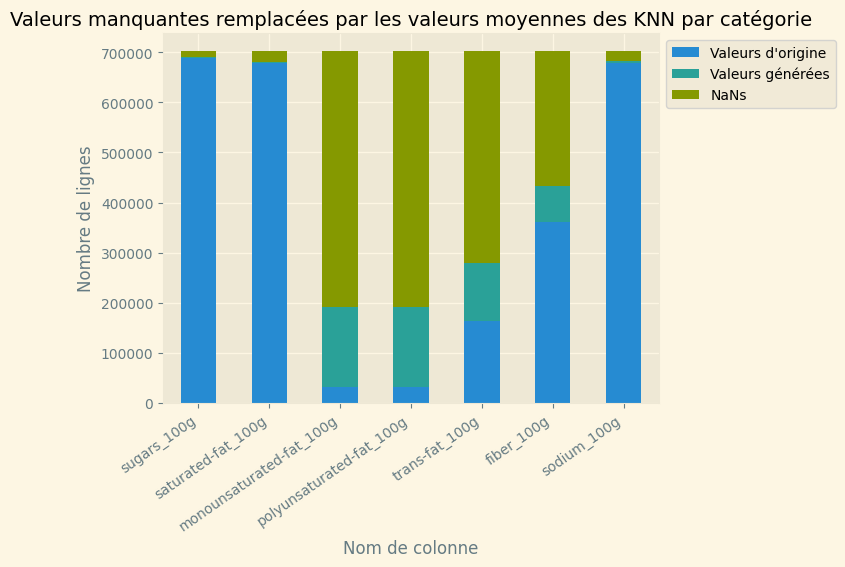

In [21]:
nutri_facts_df = pd.DataFrame(
    {
        "col": nutri_facts_to_fill,
        "Valeurs d'origine": [nutri_facts_old_new[i][0] for i in nutri_facts_to_fill],
        "Valeurs générées": [
            nutri_facts_old_new[i][1] - nutri_facts_old_new[i][0]
            for i in nutri_facts_to_fill
        ],
        "NaNs": [
            products_df.shape[0] - nutri_facts_old_new[i][1]
            for i in nutri_facts_to_fill
        ],
    }
)
nutri_facts_df.set_index("col").plot(kind="bar", stacked=True)
plt.title(
    "Valeurs manquantes remplacées par les valeurs moyennes des KNN par catégorie",
    fontsize=14,
)
plt.xlabel("Nom de colonne")
plt.ylabel("Nombre de lignes")
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(horizontalalignment="right", rotation=35)
plt.show()
